<a href="https://colab.research.google.com/github/Whoami666/HSE_Lab/blob/main/clean_models/SMOTE_schiz_models_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd drive
%cd MyDrive
%cd shiz

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/shiz


In [3]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 5.3 MB/s eta 0:00:00


In [5]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 22.1 MB/s eta 0:00:00


In [6]:
from imblearn.over_sampling import SMOTE

In [7]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

import sklearn.metrics
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection

from sklearn.model_selection import KFold

In [8]:
scoring = ['recall', 'accuracy', 'f1', 'roc_auc']

In [9]:
df = pd.read_excel('df_standard_cleaned_21feb.xlsx') 
df1d = pd.read_excel('df_standard_only1dfeatures.xlsx')

df = df.set_index('ID')
df1d = df1d.set_index('ID')
df.head(1)

,sex,tds,chroma_cens_avg,chroma_cens_std,chroma_cqt_avg,chroma_cqt_std,chroma_stft_avg,chroma_stft_std,melspectrogram_avg,melspectrogram_std,...,spectral_flatness_std,spectral_rolloff_avg,spectral_rolloff_std,tempogram_avg,tempogram_std,tonnetz_avg,tonnetz_std,zero_crossing_rate_avg,zero_crossing_rate_std,tds_binary
ID,,,,,,,,,,,,,,,,,,,,,
PD-003,1,0,0.685706,0.428088,0.425039,0.296394,0.339246,0.434412,0.327867,0.348849,...,0.31499,0.397736,0.254215,0.747885,0.719312,0.691479,0.329593,0.197304,0.281692,0


**Non-binary**

All features

In [21]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=32)

In [27]:
print("OverSampling, counts of label '2': {}".format(sum(y_train == 2)))
print("OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

OverSampling, counts of label '2': 81
OverSampling, counts of label '1': 95
OverSampling, counts of label '0': 94


In [28]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    CatBoostClassifier(),
    {
        'depth': [4,5,6,7,8,9, 10],
        'learning_rate' : [0.01,0.02,0.03,0.04],
        'iterations'    : [10, 20,30,40,50,60,70,80,90, 100],
    },
    n_iter=32,
    scoring='f1_macro',
    cv=3
)

opt.fit(X_train, y_train, logging_level='Silent')

BayesSearchCV(cv=3,
              estimator=<catboost.core.CatBoostClassifier object at 0x7f7c8585c250>,
              n_iter=32, scoring='f1_macro',
              search_spaces={'depth': [4, 5, 6, 7, 8, 9, 10],
                             'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                            100],
                             'learning_rate': [0.01, 0.02, 0.03, 0.04]})

In [29]:
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.9607716515854884
test score: 0.951854261548471
best_params: OrderedDict([('depth', 6), ('iterations', 90), ('learning_rate', 0.04)])


In [30]:
cbc1 = CatBoostClassifier(depth = opt.best_params_['depth'], 
                             iterations = opt.best_params_['iterations'],
                             learning_rate = opt.best_params_['learning_rate'])
cbc1.fit(X_train, y_train, logging_level='Silent')
y_pred = cbc1.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.88      0.92        56
           1       0.89      0.98      0.93        55
           2       1.00      1.00      1.00        69

    accuracy                           0.96       180
   macro avg       0.96      0.95      0.95       180
weighted avg       0.96      0.96      0.96       180



In [ ]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(cbc1, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(cbc1, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

Text(0.5, 0, 'Catboost Feature Importance')

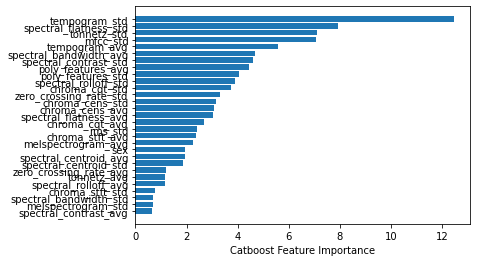

In [32]:
sorted_idx = cbc1.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], cbc1.feature_importances_[sorted_idx])
plt.xlabel("Catboost Feature Importance")


Only 1D features

In [33]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [34]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    CatBoostClassifier(),
    {
        'depth': [4,5,6,7,8,9, 10],
        'learning_rate' : [0.01,0.02,0.03,0.04],
        'iterations'    : [10, 20,30,40,50,60,70,80,90, 100],
    },
    n_iter=32,
    scoring='f1_macro',
    cv=3
)

opt.fit(X_train, y_train, logging_level='Silent')

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.9008606837258143
test score: 0.9475601640630756
best_params: OrderedDict([('depth', 8), ('iterations', 100), ('learning_rate', 0.04)])


In [35]:
cbc2 = CatBoostClassifier(depth = opt.best_params_['depth'], 
                             iterations = opt.best_params_['iterations'],
                             learning_rate = opt.best_params_['learning_rate'])
cbc2.fit(X_train, y_train, logging_level='Silent')
y_pred = cbc2.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92        55
           1       0.92      0.95      0.93        60
           2       0.98      1.00      0.99        65

    accuracy                           0.95       180
   macro avg       0.95      0.95      0.95       180
weighted avg       0.95      0.95      0.95       180



In [36]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(cbc2, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(cbc2, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

0:	learn: 1.0612419	total: 10.9ms	remaining: 1.08s
1:	learn: 1.0319211	total: 20.8ms	remaining: 1.02s
2:	learn: 0.9984435	total: 30.3ms	remaining: 981ms
3:	learn: 0.9639657	total: 40.4ms	remaining: 970ms
4:	learn: 0.9337833	total: 49.3ms	remaining: 936ms
5:	learn: 0.9067955	total: 58.4ms	remaining: 915ms
6:	learn: 0.8768049	total: 68.1ms	remaining: 905ms
7:	learn: 0.8499589	total: 77.5ms	remaining: 891ms
8:	learn: 0.8272888	total: 87.4ms	remaining: 884ms
9:	learn: 0.8040990	total: 98.2ms	remaining: 884ms
10:	learn: 0.7826801	total: 108ms	remaining: 872ms
11:	learn: 0.7615312	total: 121ms	remaining: 884ms
12:	learn: 0.7390709	total: 131ms	remaining: 878ms
13:	learn: 0.7192959	total: 143ms	remaining: 879ms
14:	learn: 0.7010930	total: 154ms	remaining: 871ms
15:	learn: 0.6836726	total: 165ms	remaining: 867ms
16:	learn: 0.6672353	total: 175ms	remaining: 856ms
17:	learn: 0.6513231	total: 185ms	remaining: 842ms
18:	learn: 0.6370033	total: 196ms	remaining: 836ms
19:	learn: 0.6214405	total: 206

Text(0.5, 0, 'Random Forest Feature Importance')

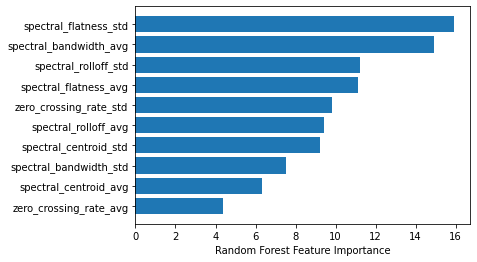

In [37]:
sorted_idx = cbc2.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], cbc2.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

**Binary**

All features

In [38]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds_binary # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

In [39]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    CatBoostClassifier(),
    {
        'depth': [4,5,6,7,8,9, 10],
        'learning_rate' : [0.01,0.02,0.03,0.04],
        'iterations'    : [10, 20,30,40,50,60,70,80,90, 100],
    },
    n_iter=32,
    scoring='f1_macro',
    cv=3
)

opt.fit(X_train, y_train, logging_level='Silent')

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.9624183006535948
test score: 0.9493100535060548
best_params: OrderedDict([('depth', 10), ('iterations', 90), ('learning_rate', 0.03)])


In [40]:
cbc3 = CatBoostClassifier(depth = opt.best_params_['depth'], 
                             iterations = opt.best_params_['iterations'],
                             learning_rate = opt.best_params_['learning_rate'])
cbc3.fit(X_train, y_train, logging_level='Silent')
y_pred = cbc3.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        28
           1       0.91      1.00      0.96        32

    accuracy                           0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



In [41]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(cbc3, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(cbc3, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

0:	learn: 0.6630572	total: 32.7ms	remaining: 2.91s
1:	learn: 0.6342020	total: 60.6ms	remaining: 2.67s
2:	learn: 0.6072906	total: 89.7ms	remaining: 2.6s
3:	learn: 0.5820837	total: 121ms	remaining: 2.61s
4:	learn: 0.5606724	total: 156ms	remaining: 2.65s
5:	learn: 0.5366750	total: 189ms	remaining: 2.64s
6:	learn: 0.5143942	total: 217ms	remaining: 2.57s
7:	learn: 0.4942916	total: 246ms	remaining: 2.52s
8:	learn: 0.4730389	total: 273ms	remaining: 2.46s
9:	learn: 0.4546170	total: 303ms	remaining: 2.43s
10:	learn: 0.4379704	total: 332ms	remaining: 2.38s
11:	learn: 0.4224820	total: 362ms	remaining: 2.35s
12:	learn: 0.4043123	total: 393ms	remaining: 2.33s
13:	learn: 0.3889144	total: 424ms	remaining: 2.3s
14:	learn: 0.3735097	total: 439ms	remaining: 2.2s
15:	learn: 0.3607582	total: 469ms	remaining: 2.17s
16:	learn: 0.3468034	total: 502ms	remaining: 2.16s
17:	learn: 0.3329073	total: 530ms	remaining: 2.12s
18:	learn: 0.3215293	total: 545ms	remaining: 2.04s
19:	learn: 0.3115579	total: 573ms	remaini

Text(0.5, 0, 'Random Forest Feature Importance')

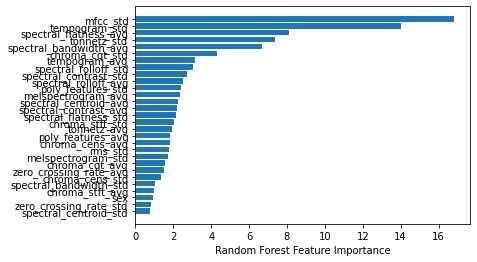

In [42]:
sorted_idx = cbc3.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], cbc3.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Only 1D features

In [43]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds_binary # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [44]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    CatBoostClassifier(),
    {
        'depth': [4,5,6,7,8,9, 10],
        'learning_rate' : [0.01,0.02,0.03,0.04],
        'iterations'    : [10, 20,30,40,50,60,70,80,90, 100],
    },
    n_iter=32,
    scoring='f1_macro',
    cv=3
)

opt.fit(X_train, y_train, logging_level='Silent')

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.8721526037315511
test score: 0.8894479484090425
best_params: OrderedDict([('depth', 9), ('iterations', 60), ('learning_rate', 0.04)])


In [45]:
cbc4 = CatBoostClassifier(depth = opt.best_params_['depth'], 
                             iterations = opt.best_params_['iterations'],
                             learning_rate = opt.best_params_['learning_rate'])
cbc4.fit(X_train, y_train, logging_level='Silent')
y_pred = cbc4.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.87        55
           1       0.86      0.95      0.91        65

    accuracy                           0.89       120
   macro avg       0.90      0.89      0.89       120
weighted avg       0.90      0.89      0.89       120



In [46]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(cbc4, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(cbc4, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

0:	learn: 0.6800291	total: 12.6ms	remaining: 743ms
1:	learn: 0.6675839	total: 26.4ms	remaining: 765ms
2:	learn: 0.6533322	total: 36.7ms	remaining: 698ms
3:	learn: 0.6441721	total: 46.8ms	remaining: 655ms
4:	learn: 0.6309075	total: 56.6ms	remaining: 623ms
5:	learn: 0.6214013	total: 65.6ms	remaining: 591ms
6:	learn: 0.6123723	total: 75.6ms	remaining: 572ms
7:	learn: 0.6020238	total: 88.3ms	remaining: 574ms
8:	learn: 0.5925215	total: 97.5ms	remaining: 553ms
9:	learn: 0.5827523	total: 106ms	remaining: 531ms
10:	learn: 0.5745040	total: 116ms	remaining: 515ms
11:	learn: 0.5646282	total: 125ms	remaining: 499ms
12:	learn: 0.5567213	total: 137ms	remaining: 495ms
13:	learn: 0.5479582	total: 148ms	remaining: 487ms
14:	learn: 0.5400940	total: 157ms	remaining: 472ms
15:	learn: 0.5326444	total: 168ms	remaining: 462ms
16:	learn: 0.5250775	total: 180ms	remaining: 455ms
17:	learn: 0.5176796	total: 189ms	remaining: 441ms
18:	learn: 0.5117186	total: 200ms	remaining: 432ms
19:	learn: 0.5045052	total: 210m

Text(0.5, 0, 'Random Forest Feature Importance')

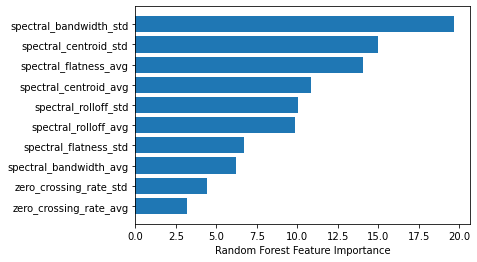

In [47]:
sorted_idx = cbc4.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], cbc4.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")